## <b> [3단계] AI 모델링
---

## 1, 2 단계에서 진행하신 내용을 아래에 그대로 진행해주세요.

---

# <b>Step 0. 라이브러리 import 및 데이터 불러오기
### **가. 라이브러리 import**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests, json

from sklearn.metrics import *
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import *
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# 크롤링
from bs4 import BeautifulSoup
import openpyxl

# Linear, Logistic
from sklearn.linear_model import LinearRegression, LogisticRegression

# knn
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# decision
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# svm
from sklearn.svm import SVC, SVR

# bagging
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# boosting
from xgboost import XGBClassifier, XGBRegressor

In [42]:
#Tensorflow 설치하기

* 데이터 프레임 관련 라이브러리

In [43]:
#라이브러리 불러오기

### **나.  학습데이터 불러오기**

In [2]:
data = pd.read_csv('preprocess_data.csv')

In [3]:
target = 'Result_v1'

### **다.  데이터 전처리**

In [4]:
x = data.drop(target, axis=1)
y = data[target]

### **라. train_test_split을 이용하여 train/test  데이터 분리**



In [5]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3)

In [6]:
# 로지스틱 회귀 pvalue 검증 시 관계 있는 feature
pvalue_col = ['url_num_hyphens_dom', 'url_path_len', 'url_domain_len', 'url_num_underscores', 'url_ip_present', "html_num_tags('script')", "html_num_tags('embed')", "html_num_tags('object')", "html_num_tags('div')", "html_num_tags('form')", "html_num_tags('a')"]

In [7]:
x_train_f = x_train[pvalue_col]
x_val_f = x_val[pvalue_col]

In [8]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.fit_transform(x_val)

x_train_sf = scaler.fit_transform(x_train_f)
x_val_sf = scaler.fit_transform(x_val_f)

### **마. Confusion Matrix 함수 정의**


#### Confusion Matrix란 Training 을 통한 Prediction 성능을 측정하기 위해 예측 value와 실제 value를 비교하기 위한 표입니다.
#### 아래 함수는 이번 과제에서 confusion matrix 결과를 보기 쉽게 표현한 것으로 사용 예를 참고하여 모델 결과 확인에 사용하시기 바랍니다.



**<span style="color:green">[참고링크] 공식 Document**</span>
 
* confusion matrix(https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [9]:
from sklearn.metrics import classification_report as creport
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [10]:
def plot_confusion_matrix(ax, matrix, labels = ['malicious','benign'], title='Confusion matrix', fontsize=9):
    ax.set_xticks([x for x in range(len(labels))])
    ax.set_yticks([y for y in range(len(labels))])

    # Place labels on minor ticks
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation='90', fontsize=fontsize, minor=True)
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=fontsize, minor=True)

    # Hide major tick labels
    ax.tick_params(which='major', labelbottom='off', labelleft='off')

    # Finally, hide minor tick marks
    ax.tick_params(which='minor', width=0)

    # Plot heat map
    proportions = [1. * row / sum(row) for row in matrix]
    ax.pcolor(np.array(proportions[::-1]), cmap=plt.cm.Blues)

    # Plot counts as text
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, int(confusion),
                        fontsize=fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')

    # Add finishing touches
    ax.grid(True, linestyle=':')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('prediction', fontsize=fontsize)
    ax.set_ylabel('actual', fontsize=fontsize)

    plt.show()

### <span style="color:blue">[예시] Confusion Matrix 사용 방법<span>

- 샘플
#### > confusion = confusion_matrix(test_y, dt_pred)
#### > fig, ax = plt.subplots(figsize=(10,3))
#### > plot_confusion_matrix(ax, confusion, fontsize=30)


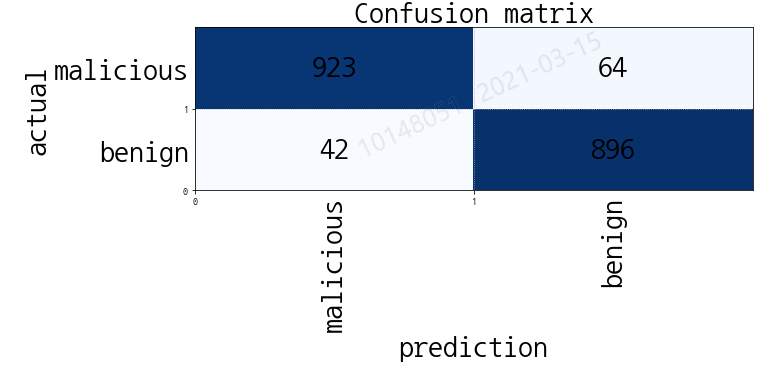

---

## <b> Q. AI 분류 모델 만들기

* 전처리한 데이터셋을 활용해 악성사이트 여부를 판별하는 AI 분류 모델을 <font color="red">최소 3개 이상 </font>만들어보세요.

In [18]:
# 2.선언 
logst_model = LogisticRegression()
knn_model = KNeighborsClassifier()
svc_model = SVC()
ran_model = RandomForestClassifier()
xgb_model = XGBClassifier()

models = {'knn_model':knn_model, 'logst_model': logst_model, 'svc_model':svc_model, 'ran_model':ran_model, 'xgb_model':xgb_model}

In [21]:
k = int(y_val.count() ** 0.5)
k

33

In [113]:
# param


params = {
    'logst_model' : {
    }
    , 'knn_model' : {
        'n_neighbors' : range(k-5, k+5)
        , 'metric': ['euclidean', 'manhattan']
    }
    , 'svc_model' : {
        'C': range(1,11)
        , 'gamma' : np.linspace(0.01,1,10)
    }
    , 'ran_model' : {
        'max_features' : range(3,8)
        , 'n_estimators' : range(40,80,5)
    }
    , 'xgb_model' : {
        'max_depth' : range(1, 6)
        , 'n_estimators':[100,150,200]
        , 'learning_rate':np.linspace(0.01,1,10)
    }
}

In [23]:
# 3. fit(), 학습
name = []
pred = []
report = []
accuracy = []
best_param = []
best_score = []
result = []

for n in models:
    grid = GridSearchCV(models[n], params[n], cv=5)
    
    if n == 'knn_model' or n == 'svc_model':
        grid.fit(x_train_s, y_train)
        pred_ = grid.predict(x_val_s)
    # elif n == 'logst_model':
    #     grid.fit(x_train_f, y_train)
    #     pred_ = grid.predict(x_val_f)
    else:
        grid.fit(x_train, y_train)
        pred_ = grid.predict(x_val)
    

    result.append(grid.cv_results_)
    best_param.append(grid.best_estimator_)
    best_score.append(grid.best_score_)
    name.append(n)
    pred.append(pred_)
    report.append(classification_report(y_val, pred_))
    accuracy.append(accuracy_score(y_val, pred_))

c:\Users\mskyu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mskyu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [28]:
for i in range(len(models)):
    print(name[i])
    print(f'best_param : {best_param[i]}')
    print(f'best_score : {best_score[i]}')
    print(f'report : {report[i]}')
    print(f'accuracy : {accuracy[i]}')
    print('*' * 50)

knn_model
best_param : KNeighborsClassifier(metric='manhattan', n_neighbors=23)
best_score : 0.8474445662768032
report :               precision    recall  f1-score   support

           0       0.77      0.89      0.83       601
           1       0.84      0.68      0.75       498

    accuracy                           0.80      1099
   macro avg       0.81      0.79      0.79      1099
weighted avg       0.80      0.80      0.79      1099

accuracy : 0.7979981801637852
**************************************************
logst_model
best_param : LogisticRegression()
best_score : 0.8064685367933724
report :               precision    recall  f1-score   support

           0       0.82      0.78      0.80       601
           1       0.75      0.80      0.78       498

    accuracy                           0.79      1099
   macro avg       0.79      0.79      0.79      1099
weighted avg       0.79      0.79      0.79      1099

accuracy : 0.7907188353048226
***************************

<pre>
knn_model
best_param : KNeighborsClassifier(metric='manhattan', n_neighbors=23)
best_score : 0.8474445662768032
report :               precision    recall  f1-score   support

           0       0.77      0.89      0.83       601
           1       0.84      0.68      0.75       498

    accuracy                           0.80      1099
   macro avg       0.81      0.79      0.79      1099
weighted avg       0.80      0.80      0.79      1099

accuracy : 0.7979981801637852
**************************************************
logst_model
best_param : LogisticRegression()
best_score : 0.8064685367933724
report :               precision    recall  f1-score   support

           0       0.82      0.78      0.80       601
           1       0.75      0.80      0.78       498

    accuracy                           0.79      1099
   macro avg       0.79      0.79      0.79      1099
weighted avg       0.79      0.79      0.79      1099

accuracy : 0.7907188353048226
**************************************************
svc_model
best_param : SVC(C=10, gamma=1.0)
best_score : 0.8333919651559455
report :               precision    recall  f1-score   support

           0       0.87      0.88      0.88       601
           1       0.85      0.84      0.85       498

    accuracy                           0.86      1099
   macro avg       0.86      0.86      0.86      1099
weighted avg       0.86      0.86      0.86      1099

accuracy : 0.8635122838944495
**************************************************
ran_model
best_param : RandomForestClassifier(max_features=5, n_estimators=60)
best_score : 0.9621581079434698
report :               precision    recall  f1-score   support

           0       0.97      0.96      0.96       601
           1       0.96      0.96      0.96       498

    accuracy                           0.96      1099
   macro avg       0.96      0.96      0.96      1099
weighted avg       0.96      0.96      0.96      1099

accuracy : 0.9617834394904459
**************************************************
xgb_model
best_param : XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2705263157894737, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=8, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)
best_score : 0.9609839485867446
report :               precision    recall  f1-score   support

           0       0.96      0.96      0.96       601
           1       0.95      0.96      0.95       498

    accuracy                           0.96      1099
   macro avg       0.96      0.96      0.96      1099
weighted avg       0.96      0.96      0.96      1099

accuracy : 0.9563239308462238
**************************************************
</pre>

In [134]:
### SVC
param = {
    'C': range(1,5)
    , 'gamma' : np.linspace(0.001,0.2,10)
}

# 'C': range(1,11)
# , 'gamma' : np.linspace(0.01,1,20)

In [135]:
grid_svc1 = GridSearchCV(svc_model, param, cv=5)
grid_svc1.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': range(1, 5),
                         'gamma': array([0.001     , 0.02311111, 0.04522222, 0.06733333, 0.08944444,
       0.11155556, 0.13366667, 0.15577778, 0.17788889, 0.2       ])})

In [138]:
pred_svc1 = grid_svc1.predict(x_val)

In [139]:
print(grid_svc1.best_estimator_)
print(grid_svc1.best_score_)
print(classification_report(y_val, pred_svc1))
print(accuracy_score(y_val, pred_svc1))

SVC(C=4, gamma=0.001)
0.885295595760234
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       557
           1       0.91      0.85      0.88       542

    accuracy                           0.88      1099
   macro avg       0.88      0.88      0.88      1099
weighted avg       0.88      0.88      0.88      1099

0.8817106460418562


In [129]:
tmp_model = SVC(C=10, gamma=1.0)
tmp_model.fit(x_train, y_train)

SVC(C=10, gamma=1.0)

In [130]:
tmp_pred = tmp_model.predict(x_val)

In [131]:
print(classification_report(y_val, tmp_pred))
print(accuracy_score(y_val, tmp_pred))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81       557
           1       1.00      0.51      0.68       542

    accuracy                           0.76      1099
   macro avg       0.84      0.76      0.74      1099
weighted avg       0.84      0.76      0.74      1099

0.7597816196542311


In [ ]:
grid_svc2 = GridSearchCV(svc_model, param, cv=5)
grid_svc2.fit(x_train_f, y_train)

In [87]:
pred_svc2 = grid_svc2.predict(x_val_f)

In [88]:
print(grid_svc1.best_estimator_)
print(grid_svc1.best_score_)
print(classification_report(y_val, pred_svc2))
print(accuracy_score(y_val, pred_svc2))

SVC(C=5, gamma=0.5)
0.7580949987816764
              precision    recall  f1-score   support

           0       0.51      0.80      0.62       557
           1       0.51      0.22      0.31       542

    accuracy                           0.51      1099
   macro avg       0.51      0.51      0.47      1099
weighted avg       0.51      0.51      0.47      1099

0.5122838944494995


In [124]:
param = {
    'max_features' : range(3,8)
    , 'n_estimators' : range(40,80,5)
}

In [ ]:
grid_ran1 = GridSearchCV(ran_model, param, cv=5)
grid_ran1.fit(x_train, y_train)

In [127]:
pred_ran1 = grid_ran1.predict(x_val)

In [128]:
print(grid_ran1.best_estimator_)
print(grid_ran1.best_score_)
print(classification_report(y_val, pred_ran1))
print(accuracy_score(y_val, pred_ran1))

RandomForestClassifier(max_features=4, n_estimators=75)
0.9641074256822613
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       557
           1       0.95      0.96      0.96       542

    accuracy                           0.96      1099
   macro avg       0.96      0.96      0.96      1099
weighted avg       0.96      0.96      0.96      1099

0.9563239308462238


In [177]:
tmp_mod = RandomForestClassifier(max_features=5, n_estimators=60, min_samples_leaf=5)
tmp_mod.fit(x_train, y_train)

RandomForestClassifier(max_features=5, min_samples_leaf=5, n_estimators=60)

In [178]:
tmp_p = tmp_mod.predict(x_val)

In [179]:
print(classification_report(y_val, tmp_p))
print(accuracy_score(y_val, tmp_p))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       548
           1       0.95      0.95      0.95       551

    accuracy                           0.95      1099
   macro avg       0.95      0.95      0.95      1099
weighted avg       0.95      0.95      0.95      1099

0.9499545040946314


In [1]:
param = {
    'max_depth' : range(2, 7)
    , 'n_estimators':[50, 70, 100, 120]
    , 'learning_rate':np.linspace(0.01,1,10)
}


NameError: name 'np' is not defined

In [ ]:
grid_xgb = GridSearchCV(xgb_model, param, cv=5)
grid_xgb.fit(x_train_f, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                  

In [608]:
test_val = pd.read_csv('test_val_1.csv')
test_val

,url_len,url_num_hyphens_dom,url_path_len,url_domain_len,url_num_dots,url_num_underscores,url_query_len,url_num_query_para,url_ip_present,url_entropy,url_port,html_num_tags('iframe'),html_num_tags('script'),html_num_tags('embed'),html_num_tags('object'),html_num_tags('div'),html_num_tags('head'),html_num_tags('body'),html_num_tags('form'),html_num_tags('a')
0,97,0,80.000000,17.0,4,0,0,0,0,4.844913,0,0,5.000000,0,0,12,1,1,1.0,3.000000
1,37,0,22.000000,15.0,3,1,0,0,0,4.246157,0,1,17.000000,0,0,158,1,1,1.0,100.000000
2,44,0,27.755814,20.0,3,3,0,0,0,4.612835,0,0,6.000000,3,3,34,1,1,0.0,136.000000
3,40,0,14.000000,26.0,2,0,0,0,0,4.238521,0,0,9.015496,0,0,29,1,1,1.0,2.000000
4,43,2,27.755814,26.0,2,0,0,0,0,4.240669,0,0,9.015496,0,0,41,1,1,1.0,67.479086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436,63,0,37.000000,17.0,4,2,0,0,0,4.738082,0,1,18.000000,0,0,79,1,1,1.0,119.000000
2437,36,0,1.000000,35.0,2,0,0,0,0,4.080351,0,0,27.000000,0,0,57,1,1,1.0,67.479086
2438,45,1,23.000000,22.0,2,0,0,0,0,4.359443,0,0,8.000000,0,0,199,1,1,2.0,67.479086
2439,24,0,10.000000,14.0,3,0,0,0,1,4.260333,0,0,3.000000,0,0,90,1,1,2.0,25.000000


In [609]:
pvalue_col

['url_num_hyphens_dom',
 'url_path_len',
 'url_domain_len',
 'url_num_underscores',
 'url_ip_present',
 "html_num_tags('script')",
 "html_num_tags('embed')",
 "html_num_tags('object')",
 "html_num_tags('div')",
 "html_num_tags('form')",
 "html_num_tags('a')"]

In [610]:
test_val_f = test_val[pvalue_col]

In [611]:
scaler = MinMaxScaler()
test_val_s = scaler.fit_transform(test_val)

In [612]:
test_val.shape

(2441, 20)

In [595]:
model = RandomForestClassifier(max_depth=20, n_estimators=130, max_features=15)
model.fit(x_train,y_train)

RandomForestClassifier(max_depth=20, max_features=15, n_estimators=130)

In [596]:
ran_pred_ = model.predict(x_val)

In [597]:
print(classification_report(y_val, ran_pred_))
print(accuracy_score(y_val, ran_pred_))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       548
           1       0.96      0.97      0.97       551

    accuracy                           0.97      1099
   macro avg       0.97      0.97      0.97      1099
weighted avg       0.97      0.97      0.97      1099

0.9654231119199272


In [347]:
ran_pred = model.predict(test_val)
pred = list(ran_pred)

In [348]:
result = {
    'id':range(0,2441)
    , 'expected' : pred
}
test_pred = pd.DataFrame(result)
test_pred['expected'] = test_pred['expected'].map({
    0:1, 1:-1
})

In [349]:
test_pred.to_csv('result_9.csv', index=False)

In [667]:
model = XGBClassifier(learning_rate=0.23, max_depth=10, n_estimators=130)
model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.23, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=130,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [668]:
pred_ = model.predict(x_val)

In [669]:
print(classification_report(y_val, pred_))
print(accuracy_score(y_val, pred_))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       548
           1       0.97      0.98      0.97       551

    accuracy                           0.97      1099
   macro avg       0.97      0.97      0.97      1099
weighted avg       0.97      0.97      0.97      1099

0.9745222929936306


In [604]:
xgb_pred = model.predict(test_val)
pred = list(xgb_pred)

In [605]:
result = {
    'id':range(0,2441)
    , 'expected' : pred
}

In [606]:
test_pred = pd.DataFrame(result)
test_pred['expected'] = test_pred['expected'].map({
    0:1, 1:-1
})

In [607]:
test_pred.to_csv('result_12.csv', index=False)

In [62]:
test_pred

,id,expected
0,0,1
1,1,-1
2,2,1
3,3,-1
4,4,1
...,...,...
2436,2436,1
2437,2437,-1
2438,2438,-1
2439,2439,-1


In [51]:
# print(grid_xgb.best_estimator_)
# print(grid_xgb.best_score_)
print(classification_report(y_val, xgb_pred))
print(accuracy_score(y_val, xgb_pred))

ValueError: Found input variables with inconsistent numbers of samples: [1099, 2441]

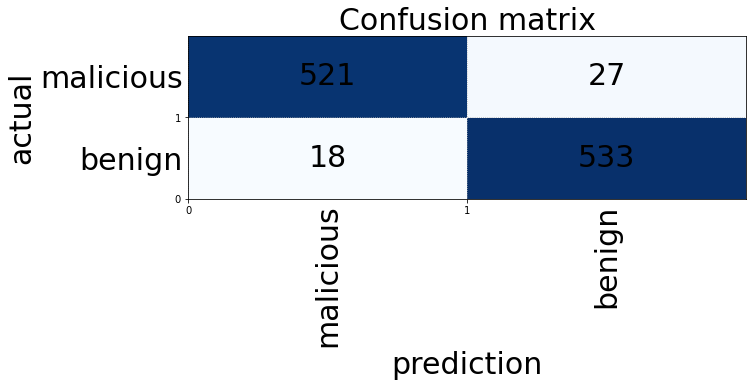

In [585]:
# Test 데이터 결과 Confusion Matrix 확인
confusion = confusion_matrix(y_val, pred_)
fig, ax = plt.subplots(figsize=(10,3))
plot_confusion_matrix(ax, confusion, fontsize=30)


In [564]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

,feature_names,feature_importance
0,html_num_tags('form'),0.282636
1,url_num_hyphens_dom,0.157340
2,html_num_tags('a'),0.125429
3,url_domain_len,0.117967
4,url_path_len,0.115624
5,url_ip_present,0.065053
6,url_num_underscores,0.052967
7,html_num_tags('script'),0.044627
8,html_num_tags('div'),0.038358
9,html_num_tags('embed'),0.000000


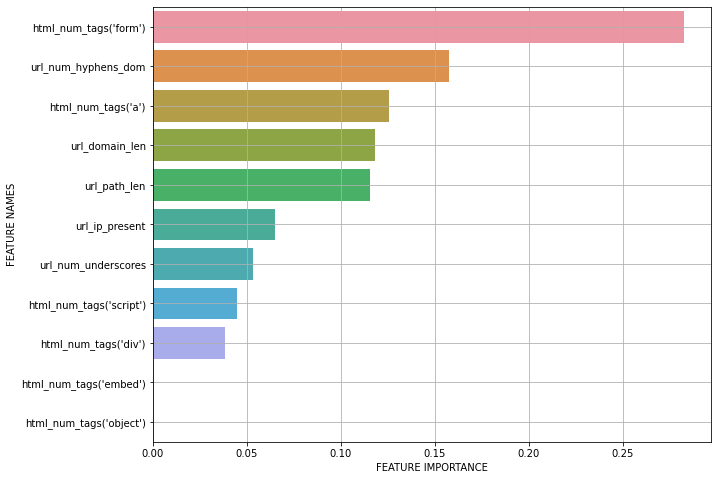

In [586]:
# Feature(특징)별 가중치 확인

plot_feature_importance(model.feature_importances_, x_train_f.columns)


In [107]:
test = pd.read_csv('test_dataset_v01.csv')
test.shape

(2441, 24)

In [108]:
test.columns

Index(['Unnamed: 0', 'url_len', 'url_num_hyphens_dom', 'url_path_len',
       'url_domain_len', 'url_hostname_len', 'url_num_dots',
       'url_num_underscores', 'url_query_len', 'url_num_query_para',
       'url_ip_present', 'url_entropy', 'url_chinese_present', 'url_port',
       'html_num_tags('iframe')', 'html_num_tags('script')',
       'html_num_tags('embed')', 'html_num_tags('object')',
       'html_num_tags('div')', 'html_num_tags('head')',
       'html_num_tags('body')', 'html_num_tags('form')', 'html_num_tags('a')',
       'html_num_tags('applet')'],
      dtype='object')

In [109]:
test.loc[test['url_domain_len'].isna(), 'url_domain_len'] = test['url_hostname_len']

In [110]:
drop_col = ['url_chinese_present', "html_num_tags('applet')", 'Unnamed: 0', 'url_hostname_len']
test = test.drop(drop_col, axis=1)

In [111]:
test.isna().sum()

url_len                      0
url_num_hyphens_dom          0
url_path_len               466
url_domain_len             101
url_num_dots                 0
url_num_underscores          0
url_query_len                0
url_num_query_para           0
url_ip_present               0
url_entropy                  0
url_port                     0
html_num_tags('iframe')      0
html_num_tags('script')    467
html_num_tags('embed')       0
html_num_tags('object')      0
html_num_tags('div')         0
html_num_tags('head')        0
html_num_tags('body')        0
html_num_tags('form')      467
html_num_tags('a')         461
dtype: int64

In [112]:
test.loc[(test['url_num_hyphens_dom'] == 0) & (test["html_num_tags('div')"] >= 70) & test["url_path_len"].isna()]
test.loc[(test['url_num_hyphens_dom'] == 0) & (test["html_num_tags('div')"] >= 70) & test["url_path_len"].isna(), "url_path_len"] = 37

In [113]:
test.loc[(test['url_num_hyphens_dom'] >= 2) & (test["html_num_tags('div')"] <= 40) & test["url_path_len"].isna()]
test.loc[(test['url_num_hyphens_dom'] >= 2) & (test["html_num_tags('div')"] <= 40) & test["url_path_len"].isna(), "url_path_len"] = 21

In [114]:
test.loc[(test['url_num_hyphens_dom'] == 0) & (test["html_num_tags('div')"] >= 70) & test["html_num_tags('script')"].isna()]
test.loc[(test['url_num_hyphens_dom'] == 0) & (test["html_num_tags('div')"] >= 70) & test["html_num_tags('script')"].isna(), "html_num_tags('script')"] = 17

In [115]:
test.loc[(test['url_num_hyphens_dom'] >= 2) & (test["html_num_tags('div')"] <= 40) & test["html_num_tags('script')"].isna()]
test.loc[(test['url_num_hyphens_dom'] >= 2) & (test["html_num_tags('div')"] <= 40) & test["html_num_tags('script')"].isna(), "html_num_tags('script')"] = 7

In [116]:
test.loc[(test['url_num_hyphens_dom'] == 0) & (test["html_num_tags('div')"] >= 70) & test["html_num_tags('a')"].isna()]
test.loc[(test['url_num_hyphens_dom'] == 0) & (test["html_num_tags('div')"] >= 70) & test["html_num_tags('a')"].isna(), "html_num_tags('a')"] = 100

In [117]:
test.loc[(test['url_num_hyphens_dom'] >= 2) & (test["html_num_tags('div')"] <= 40) & test["html_num_tags('a')"].isna()]
test.loc[(test['url_num_hyphens_dom'] >= 2) & (test["html_num_tags('div')"] <= 40) & test["html_num_tags('a')"].isna(), "html_num_tags('a')"] = 23

In [118]:
test["html_num_tags('form')"] = test["html_num_tags('form')"].fillna(1)

In [119]:
test['url_path_len'] = test['url_path_len'].fillna(test['url_path_len'].mean())
test['url_domain_len'] = test['url_domain_len'].fillna(test['url_domain_len'].mean())
test["html_num_tags('a')"] = test["html_num_tags('a')"].fillna(test["html_num_tags('a')"].mean())
test["html_num_tags('script')"] = test["html_num_tags('script')"].fillna(test["html_num_tags('script')"].mean())

In [120]:
data.loc[data['Result_v1'] == 1].describe()

,url_len,url_num_hyphens_dom,url_path_len,url_domain_len,url_num_dots,url_num_underscores,url_query_len,url_num_query_para,url_ip_present,url_entropy,...,html_num_tags('iframe'),html_num_tags('script'),html_num_tags('embed'),html_num_tags('object'),html_num_tags('div'),html_num_tags('head'),html_num_tags('body'),html_num_tags('form'),html_num_tags('a'),Result_v1
count,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000,...,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000,1806.0
mean,55.187708,0.717054,21.352159,24.075305,2.445183,0.126246,9.550941,0.211517,0.041528,4.294625,...,0.200997,6.207087,0.002215,0.003876,47.282392,1.001661,1.042082,1.223699,23.859358,1.0
std,47.387221,1.049050,27.658023,11.643451,1.767054,0.829249,35.419909,0.804145,0.199564,0.382294,...,0.822144,9.876090,0.047023,0.062154,65.582512,0.150705,0.275301,1.403523,50.785161,0.0
min,11.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.971861,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,30.000000,0.000000,1.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.080415,...,0.000000,2.000000,0.000000,0.000000,8.000000,1.000000,1.000000,1.000000,2.000000,1.0
50%,39.000000,0.000000,11.000000,22.000000,2.000000,0.000000,0.000000,0.000000,0.000000,4.237071,...,0.000000,2.000000,0.000000,0.000000,36.000000,1.000000,1.000000,1.000000,10.000000,1.0
75%,61.000000,1.000000,27.000000,29.000000,3.000000,0.000000,0.000000,0.000000,0.000000,4.460688,...,0.000000,7.000000,0.000000,0.000000,48.000000,1.000000,1.000000,1.000000,18.000000,1.0
max,456.000000,14.000000,238.000000,109.000000,26.000000,18.000000,429.000000,9.000000,1.000000,5.821782,...,12.000000,140.000000,1.000000,1.000000,512.000000,3.000000,3.000000,19.000000,780.000000,1.0


In [121]:
data.loc[data['Result_v1'] == 0].describe()

,url_len,url_num_hyphens_dom,url_path_len,url_domain_len,url_num_dots,url_num_underscores,url_query_len,url_num_query_para,url_ip_present,url_entropy,...,html_num_tags('iframe'),html_num_tags('script'),html_num_tags('embed'),html_num_tags('object'),html_num_tags('div'),html_num_tags('head'),html_num_tags('body'),html_num_tags('form'),html_num_tags('a'),Result_v1
count,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.0,1856.0,1856.000000,1856.000000,...,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.0
mean,53.973599,0.116379,37.179418,16.794181,2.586207,0.415409,0.0,0.0,0.079203,4.164252,...,0.240302,11.297953,0.033405,0.053341,93.733297,0.994612,0.991918,0.839440,107.371767,0.0
std,106.072791,0.408047,106.424455,4.870804,1.264103,1.336754,0.0,0.0,0.270127,0.393028,...,0.967066,14.427180,0.196915,0.326477,508.593468,0.139205,0.158970,1.684903,475.279052,0.0
min,6.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.0,0.0,0.000000,2.737839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,19.000000,0.000000,0.000000,14.000000,2.000000,0.000000,0.0,0.0,0.000000,3.893661,...,0.000000,2.000000,0.000000,0.000000,4.000000,1.000000,1.000000,0.000000,3.000000,0.0
50%,31.000000,0.000000,13.500000,17.000000,2.000000,0.000000,0.0,0.0,0.000000,4.127635,...,0.000000,8.000000,0.000000,0.000000,32.000000,1.000000,1.000000,1.000000,31.000000,0.0
75%,51.000000,0.000000,33.000000,18.000000,3.000000,0.000000,0.0,0.0,0.000000,4.457458,...,0.000000,17.000000,0.000000,0.000000,83.000000,1.000000,1.000000,1.000000,101.250000,0.0
max,1837.000000,5.000000,1816.000000,49.000000,32.000000,14.000000,0.0,0.0,1.000000,5.546692,...,26.000000,267.000000,3.000000,8.000000,19941.000000,2.000000,3.000000,57.000000,13451.000000,0.0


In [122]:
x_train.describe()

,url_len,url_num_hyphens_dom,url_path_len,url_domain_len,url_num_dots,url_num_underscores,url_query_len,url_num_query_para,url_ip_present,url_entropy,url_port,html_num_tags('iframe'),html_num_tags('script'),html_num_tags('embed'),html_num_tags('object'),html_num_tags('div'),html_num_tags('head'),html_num_tags('body'),html_num_tags('form'),html_num_tags('a')
count,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000
mean,53.567694,0.428794,28.711276,20.483418,2.516582,0.269996,4.287163,0.091299,0.057355,4.224193,0.001171,0.230199,8.730784,0.015607,0.027702,70.662895,0.997269,1.017558,1.062037,62.690597
std,77.921654,0.878167,74.141615,9.566197,1.522925,1.186241,24.313033,0.546308,0.232564,0.389587,0.034199,0.991018,12.831190,0.133083,0.247575,411.193702,0.135416,0.223703,1.743633,299.284982
min,6.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.737839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,1.000000,14.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.977917,0.000000,0.000000,2.000000,0.000000,0.000000,6.000000,1.000000,1.000000,0.000000,2.000000
50%,35.000000,0.000000,12.000000,17.000000,2.000000,0.000000,0.000000,0.000000,0.000000,4.188331,0.000000,0.000000,4.000000,0.000000,0.000000,33.000000,1.000000,1.000000,1.000000,16.000000
75%,54.000000,1.000000,30.000000,24.000000,3.000000,0.000000,0.000000,0.000000,0.000000,4.454755,0.000000,0.000000,12.000000,0.000000,0.000000,62.000000,1.000000,1.000000,1.000000,51.000000
max,1709.000000,14.000000,1690.000000,109.000000,26.000000,18.000000,429.000000,9.000000,1.000000,5.821782,1.000000,26.000000,267.000000,3.000000,8.000000,19941.000000,2.000000,3.000000,57.000000,13451.000000


In [123]:
test.describe()

,url_len,url_num_hyphens_dom,url_path_len,url_domain_len,url_num_dots,url_num_underscores,url_query_len,url_num_query_para,url_ip_present,url_entropy,url_port,html_num_tags('iframe'),html_num_tags('script'),html_num_tags('embed'),html_num_tags('object'),html_num_tags('div'),html_num_tags('head'),html_num_tags('body'),html_num_tags('form'),html_num_tags('a')
count,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.00000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000
mean,52.455551,0.415404,27.755814,20.285043,2.484228,0.274068,4.890619,0.092175,0.063499,4.226469,0.00041,0.211798,9.015496,0.016387,0.029906,62.399836,1.004097,1.016796,1.006145,67.479086
std,81.659909,0.804898,69.737961,8.564387,1.470703,1.199325,34.050793,0.555988,0.243908,0.395914,0.02024,0.857823,10.649203,0.145062,0.245297,143.137764,0.202403,0.227524,1.155335,313.251928
min,5.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.920018,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,4.000000,15.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.989898,0.00000,0.000000,2.000000,0.000000,0.000000,6.000000,1.000000,1.000000,0.000000,3.000000
50%,35.000000,0.000000,17.000000,18.000000,2.000000,0.000000,0.000000,0.000000,0.000000,4.198604,0.00000,0.000000,8.000000,0.000000,0.000000,32.000000,1.000000,1.000000,1.000000,23.000000
75%,53.000000,1.000000,27.755814,23.000000,3.000000,0.000000,0.000000,0.000000,0.000000,4.433584,0.00000,0.000000,11.000000,0.000000,0.000000,61.000000,1.000000,1.000000,1.000000,67.479086
max,1652.000000,6.000000,1631.000000,100.000000,24.000000,19.000000,1088.000000,12.000000,1.000000,5.972017,1.00000,26.000000,158.000000,3.000000,6.000000,3861.000000,9.000000,3.000000,19.000000,11868.000000


In [124]:
test.to_csv('test_val_1.csv', index=False)